# Preprocessing of Sentinal-1 (SAR) dataset

### Import necessary libraries

In [2]:
import os
import snappy
from snappy import ProductIO
import globe
import pandas as pd
import jpy
import glob
from glob import iglob
from os.path import join
import numpy as np
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import subprocess

# Giving input path

In [5]:
input_S1_files='Downloads/S1A_IW_GRDH_1SDV_20210302T004009_20210302T004034_036812_045409_6EC9.zip'

# Read Product

In [4]:
product_path = "Downloads/"
input_S1_files = sorted(list(iglob(join(product_path, '**', '*S1*.zip'), recursive=True)))

name, sensing_mode, product_type, polarization, height, width, band_names = ([]for i in range(7))

for i in input_S1_files:
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[4])
    polarization.append(i.split("_")[-6])
    s1_read = snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())

df_s1_read = pd.DataFrame({'Name': name, 'Sensing Mode': sensing_mode, 'Product Type': product_type, 'Polarization': polarization, 'Height': height, 'Width': width, 'Band Names': band_names})
display(df_s1_read)

,Name,Sensing Mode,Product Type,Polarization,Height,Width,Band Names
0,S1A_IW_GRDH_1SDV_20210302T004009_20210302T0040...,1SDV,20210302T004009,1SDV,16759,25344,"[Amplitude_VH, Intensity_VH, Amplitude_VV, Int..."


# Read the data

In [20]:
s1_read

org.esa.snap.core.datamodel.Product(objectRef=0x000002092A64C060)

# output_view
Output function make for define min and max value of bands, product and the bands to use in next part.

In [22]:
def output_view(product, band, min_value_VV, max_value_VV, min_value_VH, max_value_VH):
    band_data_list = []
    for i in band:
        band = product.getBand(i)
        w = band.getRasterWidth()
        h = band.getRasterHeight()
        band_data = np.zeros(w*h, np.float32)
        band.readPixels(0, 0, w, h, band_data)
        band_data.shape = h, w
        band_data_list.append(band_data)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(band_data_list[0], cmap='gray', vmin=min_value_VV, vmax=max_value_VV)
    ax1.set_title(output_bands[0])
    ax2.imshow(band_data_list[1], cmap='gray', vmin=min_value_VH, vmax=max_value_VH)
    ax2.set_title(output_bands[1])
    
    for ax in fig.get_axes():
        ax.label_outer()

# wkt reader 
Well known text it makes geometry of given file.

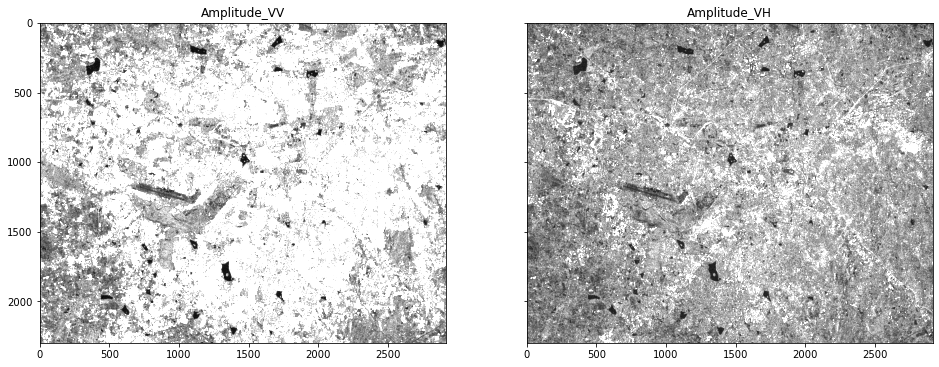

In [6]:
WKTReader = snappy.jpy.get_type('org.locationtech.jts.io.WKTReader')

wkt = "POLYGON((77.49755859375 12.882763664161187, 77.73788452148438 12.88276366416118, 77.73788452148438 13.051385737710405,77.49755859375 13.051385737710405,77.49755859375 12.882763664161187))"

geom = WKTReader().read(wkt)

parameters = snappy.HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)
subset = snappy.GPF.createProduct('Subset', parameters, s1_read)
list(subset.getBandNames())

output_bands = ['Amplitude_VV', 'Amplitude_VH']
output_view(subset, output_bands, 41, 286, 20, 160)

## Apply orbit file
I got some error. I have tried to searched and resolve that error on following website

https://forum.step.esa.int/t/orbit-file-timeout-march-2021/28621

In [7]:
parameters = snappy.HashMap()
parameters.put('Apply-Orbit-File', True)
apply_orbit = snappy.GPF.createProduct('Apply-Orbit-File', parameters, subset)
print(colored('Orbit updated successfully', 'green'))

RuntimeError: org.esa.snap.core.gpf.OperatorException: qc.sentinel1.eo.esa.int

# Thermal Noise Removal 
Thermal energy which generated in background by receiver. It skews radar reflectivity towards higher values. Level 1 product provide LUT for each measurement dataset which can be used to remove noise.

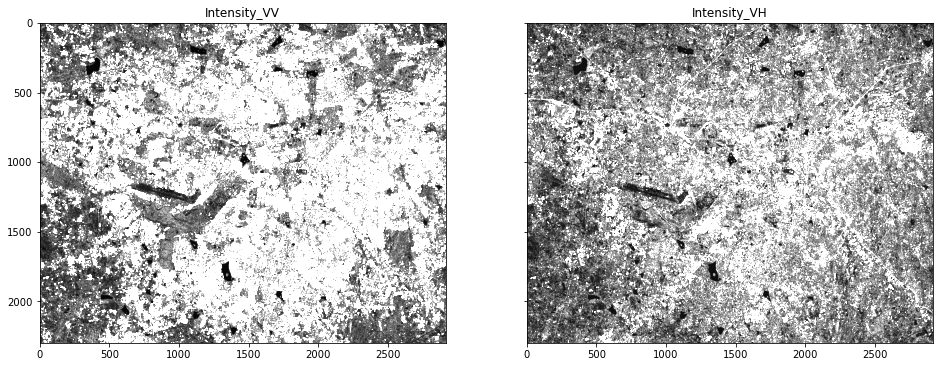

In [11]:
parameters = snappy.HashMap()
parameters.put('removeThermalNoise', True)
thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, subset)

output_bands = ['Intensity_VV', 'Intensity_VH']
output_view(thermal_noise, output_bands, 0.02, 99376.52, 0.27, 18471.83)

## Radiometric Correction - 
Radiometric correction is necessary for the pixel values to truly represent backscatter of the reflecting surface. It is necessary to allow a valid conversion of the observed pixel intensity into a physical relevant unit.

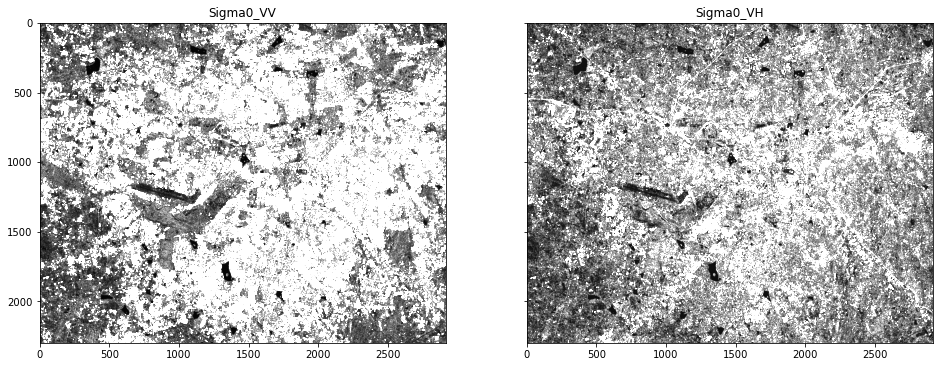

In [13]:
parameters = snappy.HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
parameters.put('selectedPolarisations', 'VH,VV')
parameters.put('outputImageScaleInDb', False)
calibrated = snappy.GPF.createProduct("Calibration", parameters, thermal_noise)

output_bands = ['Sigma0_VV', 'Sigma0_VH']
output_view(calibrated, output_bands, 0.00, 0.28, 0.00,0.05)

## Speckle Filtering
SAR images have salt and pepper like texturing called speckle which degrade the quality that's why for spackle reduction i have used speckle filter. 

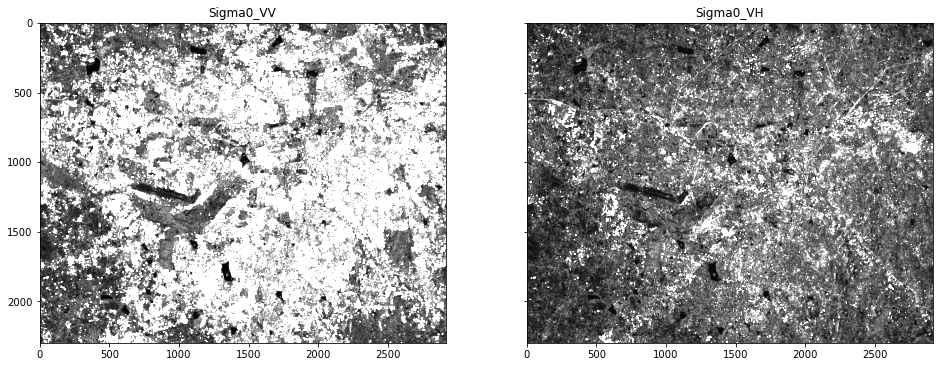

In [14]:
parameters = snappy.HashMap()
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 5)
parameters.put('filterSizeY', 5)
speckle = snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated)

output_bands = ['Sigma0_VV', 'Sigma0_VH']
output_view(speckle, output_bands, 0.00, 0.31, 0.00, 0.08)

## Terrain Correction
Due to topographical variation of scene, tilt of sensor distance can be distorted. Terrain correction compensate this distortion.

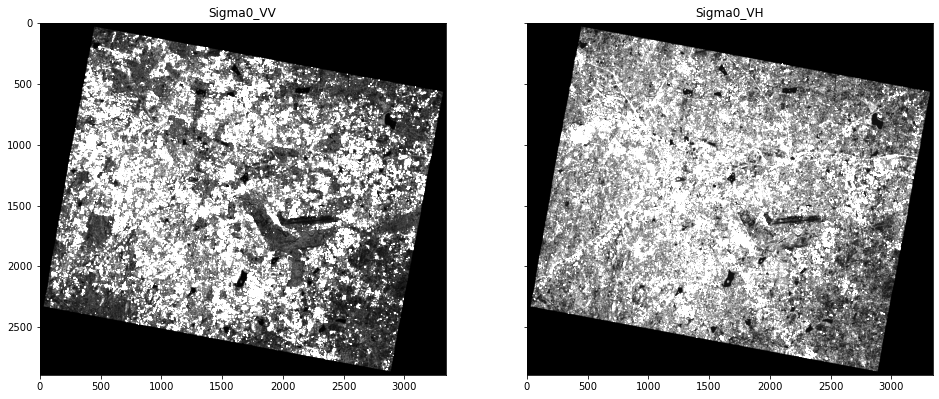

In [15]:
proj = '''PROJCS["UTM Zone 43 / World Geodetic System 1984", 
       GEOGCS["World Geodetic System 1984", 
              DATUM["World Geodetic System 1984", 
                    SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]],
                    AUTHORITY["EPSG","6326"]],
              PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]],
              UNIT["degree", 0.017453292519943295], 
              AXIS["Geodetic longitude", EAST], 
              AXIS["Geodetic latitude", NORTH]], 
       PROJECTION["Transverse_Mercator"], 
       PARAMETER["central_meridian", 75.0], 
       PARAMETER["latitude_of_origin", 0.0], 
       PARAMETER["scale_factor", 0.9996], 
       PARAMETER["false_easting", 500000.0], 
       PARAMETER["false_northing", 0.0], 
       UNIT["m", 1.0], 
       AXIS["Easting", EAST], 
       AXIS["Northing", NORTH]]'''

parameters = snappy.HashMap()
parameters.put('demName', 'SRTM 1Sec HGT')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('mapProjection', proj)
parameters.put('nodataValueAtSea', False)
parameters.put('saveSelectedSourceBand', True)

terrain_correction = snappy.GPF.createProduct('Terrain-Correction', parameters, speckle)

output_bands = ['Sigma0_VV', 'Sigma0_VH']
output_view(terrain_correction, output_bands, 0.00, 0.49, 0.00, 0.05)

## Writing to a GeoTiFF
Store output file into GeoTiFF format

In [19]:
from termcolor import colored

output_name = 'Downloads/20210302_Thm_Cal_Spk_TC'

snappy.ProductIO.writeProduct(terrain_correction, output_name, 'GeoTIFF')
print(colored('Product successfully saved in: ', 'green'), output_name)

Product successfully saved in:  Downloads/20210302_Thm_Cal_Spk_TC
